In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline as uvspline
from datetime import datetime
from exploration.config import mongo_inst
from mlpp.data_collection.sample_func import sampleFuncGenerator as sfg

In [4]:
 NUM_BINS = 200
MAX_PP = 7000
DATE_LIMIT = datetime(2019,1,1)

osu_random_db = mongo_inst['osu_random_db']

osu_dump = (osu_random_db['osu_scores_high'], osu_random_db['osu_user_stats'])
osu_scores_high, osu_user_stats = osu_dump

val_random_db = mongo_inst['val_random_db']
val_dump = (val_random_db['osu_scores_high'], val_random_db['osu_user_stats'])

generator = sfg(date_limit = DATE_LIMIT, max_pp = MAX_PP, n_bins = NUM_BINS)

In [363]:
cache = np.zeros((NUM_BINS, NUM_BINS))

for i in tqdm(range(NUM_BINS)):
    j = i * 35

    u_bins_score_cnt = np.zeros(NUM_BINS)
    pipeline = generator.range_score_hist_pipeline(val_dump[1], j, j + 35)

    for bin_cnt in val_dump[0].aggregate(pipeline):
        cache[i][int(bin_cnt['_id'])] = bin_cnt['count']

100%|██████████| 200/200 [00:15<00:00, 12.99it/s]


In [369]:
A = cache.T
b = np.full(200, val_dump[0].count() / NUM_BINS * .01)
n = len(b)

In [376]:
bounds = np.column_stack((pdf_fit[::35]*.25, np.full(NUM_BINS, .5)) )

In [378]:
fun_reg = lambda x: np.linalg.norm(np.dot(A,x)-b)
fun_mse = lambda x: np.linalg.norm(((np.dot(A,x)-b) ** 2).mean())

sol_reg = minimize(fun_reg, np.zeros(n), method='L-BFGS-B', bounds=bounds)
sol_mse = minimize(fun_mse, np.zeros(n), method='L-BFGS-B', bounds=bounds)

In [379]:
y_reg, y_mse = sol_reg['x'], sol_mse['x']

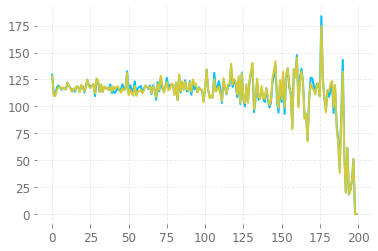

In [380]:
plt.plot(A @ y_reg)
plt.plot(A @ y_mse)

In [243]:
x = np.arange(200)
ys = uvspline(x, sorted(y_reg), s = .02)

In [343]:
borders = np.column_stack((pdf_fit[::35]*.5, pdf_fit[::35]*1.25) )

In [338]:
borders[0]

array([0.00029229, 0.00048716])

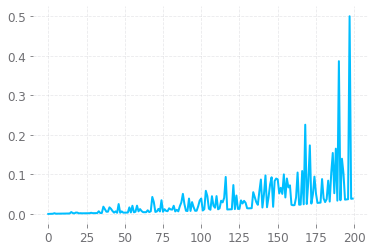

In [383]:
plt.plot(y_mse)
# plt.plot(sorted(y_reg))
# plt.plot(ys(np.arange(200)))

In [290]:
sample_pp, sample_users = generator.simulate(*val_dump, np.repeat(y_reg, 35))
# sample_pp, sample_users = generator.simulate(*val_dump, ys(np.arange(7000)/35))

In [295]:
def test_fit(fit, dump = osu_dump, trials = 10):
    err = 0
    for _ in tqdm(range(trials)):
        sample_pp, sample_users = generator.simulate(*dump, fit)
        err += sfg.prop_displaced(sample_pp)
    return err / trials

In [306]:
greedy_fit = np.load("exploration/skill_biased_sampling_function/greedy_sample_func.npy")
pdf_fit = np.load("exploration/skill_biased_sampling_function/pdf_sample_func.npy")

In [305]:
test_fit(greedy_fit, val_dump, 50)

100%|██████████| 50/50 [00:27<00:00,  1.84it/s]


0.17254564341709633

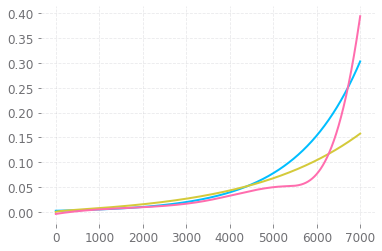

In [312]:
plt.plot(greedy_fit)
plt.plot(pdf_fit)
plt.plot(ys(np.arange(7000)/35))

In [307]:
test_fit(pdf_fit, val_dump, 50)

100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


0.17699346812108774

In [382]:
test_fit(np.repeat(y_mse, 35), val_dump, 50)

100%|██████████| 50/50 [00:15<00:00,  3.28it/s]


0.20153901708078176

(array([ 328.,  392.,  618.,  591.,  639.,  527.,  466.,  780.,  540.,
         606.,  492.,  537.,  556.,  653.,  807., 1193.,  975.,  262.,
         442.,  365.,  747.,  581.,  643.,  285.,  213.,  207.,  261.,
         227.,   65.,  607.,  732.,  607.,  258.,  112.,  224.,  263.,
         164.,   44.,   73.,  167.,  303.,  502.,  795.,  354.,  545.,
         516., 1006.,   59.,  115.,  150.]),
 array([6.99489020e-01, 1.38741815e+02, 2.76784140e+02, 4.14826466e+02,
        5.52868791e+02, 6.90911117e+02, 8.28953442e+02, 9.66995768e+02,
        1.10503809e+03, 1.24308042e+03, 1.38112274e+03, 1.51916507e+03,
        1.65720740e+03, 1.79524972e+03, 1.93329205e+03, 2.07133437e+03,
        2.20937670e+03, 2.34741902e+03, 2.48546135e+03, 2.62350367e+03,
        2.76154600e+03, 2.89958833e+03, 3.03763065e+03, 3.17567298e+03,
        3.31371530e+03, 3.45175763e+03, 3.58979995e+03, 3.72784228e+03,
        3.86588460e+03, 4.00392693e+03, 4.14196926e+03, 4.28001158e+03,
        4.41805391e+03, 

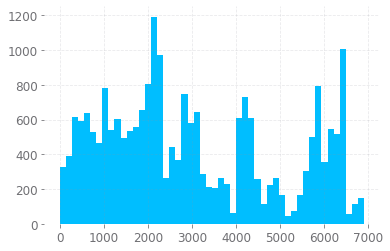

In [289]:
plt.hist(sample_pp, bins = 50)